In [95]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet

os.makedirs("data", exist_ok=True)
print("Ready. Put your CSV inside: data/")


Ready. Put your CSV inside: data/


### Step 1: Create Data Folder & Load the CSV File

This cell ensures that the `data/` directory exists.  
It then loads the CSV file: **Campaign budget analysis data export.csv**.

- If the CSV file is missing, it raises a clear error.
- Skips the first 2 rows because Google Ads exports include headers twice.
- Prints the shape of the loaded dataset.

Make sure you place your CSV file inside:

```
data/Campaign budget analysis data export.csv
```


In [96]:
file_path = "data/Campaign budget analysis data export.csv"

import os
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV not found at {file_path}. Place it in the data/ folder.")

df = pd.read_csv(file_path, skiprows=2)
print("CSV loaded. Shape:", df.shape)
df.head()


CSV loaded. Shape: (7370, 11)


,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
0,SBR Pravanika | Search | 25 Nov 22,NaN,19031976471,2000.0,0,0,INR,0.00,0,0.00,0.0
1,Valmark Cityville | Search | 25 Nov 22,22-11-24,19038490303,5000.0,0,0,INR,0.00,0,0.00,0.0
2,SBR Pravanika | Search | 25 Nov 22,2022-11-25,19031976471,2000.0,3,34,INR,411.98,8.82%,137.33,0.0
3,Valmark Cityville | Search | 25 Nov 22,2022-11-25,19038490303,5000.0,5,48,INR,870.50,10.42%,174.10,0.0
4,SBR Pravanika | Search | 25 Nov 22,2022-11-26,19031976471,2000.0,11,62,INR,1147.28,17.74%,104.30,2.0


### Step 2: Clean and Prepare the Dataset

This cell:

- Renames columns to shorter and consistent names  
- Parses the "Day" column as a proper datetime  
- Removes invalid date rows  
- Cleans numeric columns (removes commas and `%` signs)
- Converts cleaned strings into numeric format  
- Creates a backup copy `original_df` for comparison

This ensures the dataset is clean before analysis.


In [97]:
df = df.rename(columns={
    "Campaign name": "Campaign",
    "Impressions": "Impr.",
})

# Parse dates
df["Day"] = pd.to_datetime(df["Day"], errors="coerce")

df = df.dropna(subset=["Day"]).sort_values("Day")

# Clean numeric fields
numeric_cols = ["Budget", "Clicks", "Impr.", "Cost", "CTR", "Avg. CPC", "Conversions"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("%", "", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

original_df = df.copy()

print("\nRows AFTER cleaning:", len(df))
print("Data cleaned and original_df saved.")
df.head()




Rows AFTER cleaning: 7369
Data cleaned and original_df saved.


C:\Users\CEPL.DESKTOP-302PV1H\AppData\Local\Temp\ipykernel_33840\1891681839.py:7: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
2,SBR Pravanika | Search | 25 Nov 22,2022-11-25,19031976471,2000.0,3,34,INR,411.98,8.82,137.33,0.0
3,Valmark Cityville | Search | 25 Nov 22,2022-11-25,19038490303,5000.0,5,48,INR,870.50,10.42,174.10,0.0
4,SBR Pravanika | Search | 25 Nov 22,2022-11-26,19031976471,2000.0,11,62,INR,1147.28,17.74,104.30,2.0
5,Valmark Cityville | Search | 25 Nov 22,2022-11-26,19038490303,5000.0,5,65,INR,738.82,7.69,147.76,0.0
6,SBR Pravanika | Search | 25 Nov 22,2022-11-27,19031976471,2000.0,10,56,INR,1469.71,17.86,146.97,12.0


### 📊 Step 3: Visualize Metrics vs Cost (Before Filtering)

This cell generates **scatter plots** for the following metrics:

- Clicks  
- Impressions  
- Conversions  
- CTR  
- Avg CPC  

Each plot shows the relationship between **Cost (X-axis)** and the metric on **Y-axis**, grouped by campaign.

`opacity=0.8` makes points slightly transparent so overlapping data is visible.


In [98]:
print("📊 Scatter Plots BEFORE Filtering")

metrics_to_plot = ["Clicks", "Impr.", "Conversions", "CTR", "Avg. CPC"]

for metric in metrics_to_plot:
    if metric in original_df:
        fig = px.scatter(
            original_df,
            x="Cost",
            y=metric,
            color="Campaign",
            title=f"{metric} vs Cost (Before Filtering)",
            opacity=0.8
        )
        fig.update_layout(showlegend=False)
        fig.show()


📊 Scatter Plots BEFORE Filtering


### Step 4: Apply Data Filters

This cell removes:

- The first **10 days** of each campaign  
- Rows where **Cost = 0** (invalid for modelling)  
- Rows where **Clicks = 0**  

It ensures only meaningful performance data is used for modelling.


In [99]:
# Remove first 10 days of each campaign
df["Start_Day"] = df.groupby("Campaign")["Day"].transform("min")
df = df[df["Day"] >= df["Start_Day"] + pd.Timedelta(days=9)]
df = df.drop(columns=["Start_Day"])

df = df[df["Cost"] > 0] 
df = df[df["Clicks"] > 0] 

print("Zero-Spend and Zero-Click filters applied — cleaned data ready.")
print("Rows AFTER cleaning the data:",len(df))
df.head()


Zero-Spend and Zero-Click filters applied — cleaned data ready.
Rows AFTER cleaning the data: 6410


,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
37,SBR Pravanika | Search | 25 Nov 22,2022-12-04,19031976471,2000.0,2,12,INR,62.89,16.67,31.45,0.0
38,Valmark Cityville | Search | 25 Nov 22,2022-12-04,19038490303,5000.0,29,419,INR,4141.15,6.92,142.80,0.0
42,Valmark Cityville | Search | 25 Nov 22,2022-12-05,19038490303,5000.0,38,520,INR,6236.05,7.31,164.11,2.0
41,SBR Pravanika | Search | 25 Nov 22,2022-12-05,19031976471,2000.0,4,37,INR,510.76,10.81,127.69,0.0
45,SBR Pravanika | Search | 25 Nov 22,2022-12-06,19031976471,2000.0,5,33,INR,941.01,15.15,188.20,2.0


### Step 5: Visualize Metrics vs Cost (After Filtering)

Generates scatter plots again (just like before) but now using the **filtered dataset**.

This helps visualize the effect of cleaning and filtering.


In [100]:
print("📊 Scatter Plots AFTER Filter")

for metric in metrics_to_plot:
    if metric in df.columns:
        fig = px.scatter(
            df,
            x="Cost",
            y=metric,
            color="Campaign",
            title=f"{metric} vs Cost (After Filtering)",
            opacity=0.8
        )
        fig.update_layout(showlegend=False)
        fig.show()


📊 Scatter Plots AFTER Filter


### 🔮 Step 6: Prophet Forecasting Function

This function prepares a daily time series for a given metric and uses **Facebook Prophet** to:

- Train a forecasting model  
- Predict the next **30 days**  
- Return both actual + forecasted data

Prophet requires columns named:
- `ds` = date  
- `y` = metric value


In [101]:
def forecast_metric(df, metric):
    temp = df.groupby("Day")[metric].sum().reset_index()
    temp = temp.rename(columns={"Day": "ds", metric: "y"})
    
    model = Prophet()
    model.fit(temp)
    
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    return forecast, temp


### Step 7: Forecast Major Metrics

For each metric (Clicks, Impressions, Cost, Conversions):

- Fit a Prophet model  
- Calculate the next 30 days forecast  
- Plot Actual vs Predicted values  

This gives insight into future performance trends.


In [102]:
for metric in ["Clicks", "Impr.", "Cost", "Conversions"]:
    if metric in df.columns:
        print(f"\n Forecasting {metric}...\n")
        forecast, actual = forecast_metric(df, metric)

        latest_date = actual["ds"].max()    
        future_forecast = forecast[forecast["ds"] > latest_date]

        fig = px.line()
        fig.add_scatter(x=actual["ds"], y=actual["y"], mode="lines", name="Actual")
        fig.add_scatter(x=future_forecast["ds"], y=future_forecast["yhat"], mode="lines", name="Predicted (Future)")
        fig.update_layout(title=f"{metric} Forecast (Next 30 Days)")
        fig.show()



 Forecasting Clicks...



16:07:37 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing



 Forecasting Impr....



16:07:39 - cmdstanpy - INFO - Chain [1] start processing
16:07:39 - cmdstanpy - INFO - Chain [1] done processing



 Forecasting Cost...



16:07:40 - cmdstanpy - INFO - Chain [1] start processing
16:07:40 - cmdstanpy - INFO - Chain [1] done processing



 Forecasting Conversions...



16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:07:41 - cmdstanpy - INFO - Chain [1] done processing


## Prepare Daily Time Series

This section converts campaign-level logs into a daily aggregated series:

- Aggregates daily total cost  
- Aggregates total metric (e.g., Clicks)
- Ensures positive, valid rows only  
- Provides a before/after report showing data retention and cleanup impact  

Output: a clean daily time-series used for modeling.


In [103]:
def prepare_series(df, metric):
    temp = df.groupby("Day").agg(
        Cost=('Cost', 'sum'),
        y=(metric, 'sum')
    ).reset_index().rename(columns={"Day": "ds"})
    
    temp = temp[(temp["Cost"] > 0) & (temp["y"] >= 0)]
    return temp



def show_series_report(df, metric):
    print("PREPARE_SERIES() — BEFORE vs AFTER REPORT\n")

    before_rows = len(df)

    temp = prepare_series(df, metric)
    after_rows = len(temp)

    removed = before_rows - after_rows
    percent_removed = (removed / before_rows) * 100 if before_rows > 0 else 0

    report_df = pd.DataFrame({
        "Stage": ["Before prepare_series", "After prepare_series"],
        "Row Count": [before_rows, after_rows],
        "Rows Removed": [0, removed],
        "Percent Removed": [0, round(percent_removed, 2)]
    })

    print(report_df)
    print("\n Preview of processed series:\n")
    display(temp.head())

    return temp


series_output = show_series_report(df, "Clicks")


PREPARE_SERIES() — BEFORE vs AFTER REPORT

                   Stage  Row Count  Rows Removed  Percent Removed
0  Before prepare_series       6410             0             0.00
1   After prepare_series       1058          5352            83.49

 Preview of processed series:



,ds,Cost,y
0,2022-12-04,4204.04,31
1,2022-12-05,6746.81,42
2,2022-12-06,7276.45,62
3,2022-12-07,12982.80,83
4,2022-12-08,12128.72,79


## Remove Outliers Using Isolation Forest

This step identifies and removes data anomalies using IsolationForest:

- Detects unusual Cost–Clicks relationships  
- Ensures the model is not influenced by extreme values  
- Provides a before/after comparison report  

Purpose: improve the accuracy and stability of the ML model.


In [104]:
from sklearn.ensemble import IsolationForest

def remove_outliers(temp, contamination=0.02):
    if len(temp) < 10:
        return temp

    iso = IsolationForest(contamination=contamination, random_state=42)
    mask = iso.fit_predict(temp[["Cost", "y"]]) == 1

    filtered = temp[mask]
    return filtered if len(filtered) >= len(temp) * 0.5 else temp



def show_outlier_report(temp):
    print("OUTLIER REMOVAL — BEFORE vs AFTER REPORT\n")

    before_rows = len(temp)

    filtered = remove_outliers(temp)
    after_rows = len(filtered)

    removed = before_rows - after_rows
    percent_removed = (removed / before_rows) * 100 if before_rows > 0 else 0

    report_df = pd.DataFrame({
        "Stage": ["Before Outlier Removal", "After Outlier Removal"],
        "Row Count": [before_rows, after_rows],
        "Rows Removed": [0, removed],
        "Percent Removed": [0, round(percent_removed, 2)]
    })

    print(report_df)
    print("\n Preview AFTER outlier removal:\n")
    display(filtered.head())

    return filtered


temp_after_prepare = prepare_series(df, "Clicks")
temp_after_outliers = show_outlier_report(temp_after_prepare)



OUTLIER REMOVAL — BEFORE vs AFTER REPORT

                    Stage  Row Count  Rows Removed  Percent Removed
0  Before Outlier Removal       1058             0             0.00
1   After Outlier Removal       1036            22             2.08

 Preview AFTER outlier removal:



,ds,Cost,y
0,2022-12-04,4204.04,31
1,2022-12-05,6746.81,42
2,2022-12-06,7276.45,62
3,2022-12-07,12982.80,83
4,2022-12-08,12128.72,79


## Advanced Campaign Segmentation (Guaranteed 3–4 Segments)

This is a *major* upgrade over basic KMeans segmentation.

The improved segmentation:
- Builds strong performance features (CPC, CPA, CTR, Efficiencies, Size Index)  
- Applies StandardScaler for normalization  
- Adds small noise to avoid identical points  
- Ensures at least 2 valid feature dimensions  
- Uses KMeans with strong initialization (n_init=20)  
- ALWAYS produces multiple meaningful clusters  

Output:
A new `segment` column added to `df`, grouping campaigns into 2–4 clusters.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def improved_segment_by_campaign(df, n_segments=4):
    agg = df.groupby("Campaign").agg({
        "Cost": "sum",
        "Clicks": "sum",
        "Impr.": "sum",
        "Conversions": "sum"
    })

    agg["CPC"] = agg["Cost"] / agg["Clicks"].replace(0, np.nan)
    agg["CPA"] = agg["Cost"] / agg["Conversions"].replace(0, np.nan)
    agg["CTR"] = agg["Clicks"] / agg["Impr."].replace(0, np.nan)
    agg["Click_Eff"] = agg["Clicks"] / agg["Cost"].replace(0, np.nan)
    agg["Conv_Eff"] = agg["Conversions"] / agg["Cost"].replace(0, np.nan)
    agg["Size_Index"] = agg["Cost"] + agg["Clicks"] + agg["Impr."]

    agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

    features = [f for f in ["CPC", "CPA", "CTR", "Click_Eff", "Conv_Eff", "Size_Index"] if f in agg.columns]
    X = agg[features].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled = X_scaled + np.random.normal(0, 0.01, X_scaled.shape)

    if X_scaled.shape[1] == 1:
        X_scaled = np.hstack([X_scaled, X_scaled * 0.5])

    k = min(n_segments, len(agg))
    k = max(k, 2)
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    agg["segment"] = km.fit_predict(X_scaled)

    seg_map = agg["segment"].to_dict()
    df["segment"] = df["Campaign"].map(seg_map).fillna(-1).astype(int)
    return df

df_seg = improved_segment_by_campaign(df, n_segments=4)
print("Segment distribution:\n", df_seg["segment"].value_counts())


Segment distribution:
 segment
0    3235
1    3089
3      77
2       9
Name: count, dtype: int64


### Step 10: Fit Regression Models (Degree 1, 2, 3)

This function:

- Tests Linear (degree 1), Polynomial degree 2, Polynomial degree 3  
- Computes RMSE & R² for each  
Example of RMSE:
    Degree 1 - RMSE = 52.77,
    Degree 2 - RMSE = 51.59,
    Degree 3 - RMSE = 51.50 ← lowest RMSE (best)
- Selects the best model based on lowest RMSE

Example of R²:
    Degree 1 - R² = 0.549
    Degree 2 - R² = 0.569
    Degree 3 - R² = 0.571 ← highest R²
- So the degree-3 model explains slightly more of the pattern in your data.

This helps find the **best cost → metric relationship**.


In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

def fit_models_and_select(temp, degrees=(1,2,3)):
    X = temp[['Cost']].values
    y = temp['y'].values

    results = {}

    for d in degrees:
        if d == 1:
            model = LinearRegression()
        else:
            model = make_pipeline(
                PolynomialFeatures(d, include_bias=False),
                LinearRegression()
            )

        model.fit(X, y)
        y_pred = model.predict(X)

        results[d] = {
            "model": model,
            "rmse": np.sqrt(mean_squared_error(y, y_pred)),
            "r2": r2_score(y, y_pred)
        }

    best = min(results.keys(), key=lambda k: results[k]["rmse"])
    results["best_degree"] = best
    return results



In [107]:
def show_model_report(temp, metric):
    print(f"\n MODEL FIT REPORT for {metric}\n")

    results = fit_models_and_select(temp)

    rows = []
    for d in [1,2,3]:
        rows.append([
            d,
            results[d]["rmse"],
            results[d]["r2"]
        ])

    report_df = pd.DataFrame(rows, columns=["Degree", "RMSE", "R²"])

    print("Model performance for each degree:\n")
    print(report_df)

    print(f"\nBest Degree Selected: {results['best_degree']}")
    return results


temp_after_prepare = prepare_series(df, "Clicks")
temp_after_outliers = remove_outliers(temp_after_prepare)

model_results = show_model_report(temp_after_outliers, "Clicks")



 MODEL FIT REPORT for Clicks

Model performance for each degree:

   Degree       RMSE        R²
0       1  52.779277  0.549617
1       2  51.591788  0.569656
2       3  51.506179  0.571083

Best Degree Selected: 3


## Invert Model to Predict Required Cost

This function solves the inverse problem:

**Given a target number of clicks → find the required cost**

Supports:
- Linear models
- Polynomial models
- Complex multi-root equations
- Safe extrapolation if target is beyond historical range  

Used inside each segment to compute “Estimated Cost for X Clicks”.


In [108]:
def invert_model_for_target(model, degree, target, allow_extrapolation=True):

    if degree == 1:
        coef = model.coef_[0]
        intercept = model.intercept_
        if coef == 0:
            return None
        return (target - intercept) / coef

    poly = model.named_steps["polynomialfeatures"]
    lr = model.named_steps["linearregression"]

    coef = lr.coef_
    intercept = lr.intercept_

    powers = []
    for name in poly.get_feature_names_out(["Cost"]):
        if "^" in name:
            powers.append(int(name.split("^")[1]))
        elif name == "Cost":
            powers.append(1)
        else:
            powers.append(0)

    max_pow = max(powers)
    asc = np.zeros(max_pow + 1)
    asc[0] = intercept

    for c, p in zip(coef, powers):
        asc[p] += c

    desc = asc[::-1]
    desc[-1] -= target

    roots = np.roots(desc)
    valid = [float(r.real) for r in roots if np.isreal(r) and r.real >= 0]

    if valid:
        return min(valid)

    if not allow_extrapolation:
        return None

    for c in range(100, 200000, 200):
        if model.predict(np.array([[c]]))[0] >= target:
            return c

    return None


## Bind Predict Function Per Segment

Python closures cause a common bug where every segment uses the last model.

This fix:
- Creates a unique `predict_cost()` function for each segment  
- Binds the correct model + degree immediately  
- Ensures predictions are accurate and segment-specific  


In [109]:
def make_predict_cost(model, degree):
    return lambda target: invert_model_for_target(model, degree, target)


## Build Multi-Segment Cost Prediction Pipeline

This function:
1. Applies segmentation  
2. Prepares the time-series  
3. Removes outliers  
4. Fits ML models  
5. Stores each segment’s:
   - Data  
   - Fitted model  
   - Model statistics  
   - Prediction function  

Output:
`predictor` = a complete structure containing results for all segments.


In [110]:
def build_cost_predictor(df, metric, segmentation=True, n_segments=4):
    result = {"metric": metric, "segments": {}}

    work = df.copy()

    if segmentation:
        work = improved_segment_by_campaign(work, n_segments)
        segments = sorted(work["segment"].unique())
    else:
        segments = [None]

    for seg in segments:

        seg_df = work if seg is None else work[work["segment"] == seg]

        temp = prepare_series(seg_df, metric)
        temp = remove_outliers(temp)

        if len(temp) < 5:
            result["segments"][seg] = {"error": "Insufficient data"}
            continue

        models = fit_models_and_select(temp)
        best = models["best_degree"]
        model = models[best]["model"]

        predict_cost = make_predict_cost(model, best)

        result["segments"][seg] = {
            "samples": len(temp),
            "best_degree": best,
            "model": model,
            "stats": models,
            "data": temp,
            "predict_cost": predict_cost
        }

    return result


## Plot Fitted Cost Curve (Matplotlib)

Visualizes:
- Actual Cost vs Click data points  
- Fitted polynomial curve  
- Curve shape and slope  

Useful for understanding:
- Segment efficiency  
- Linear or nonlinear behavior  
- Realistic growth patterns  


In [111]:
import matplotlib.pyplot as plt

def plot_fitted_curve(temp, model, degree, metric):
    X = temp["Cost"].values.reshape(-1,1)
    y = temp["y"].values

    X_smooth = np.linspace(X.min(), X.max(), 300).reshape(-1,1)
    y_pred = model.predict(X_smooth)

    plt.figure(figsize=(10,5))
    plt.scatter(X, y, alpha=0.4, label="Actual")
    plt.plot(X_smooth, y_pred, linewidth=2, label=f"Degree {degree}")
    plt.title(f"Cost → {metric} Curve")
    plt.xlabel("Cost")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()



## Interactive Multi-Segment Cost Prediction Chart (Plotly)

Creates an interactive chart showing:
- For each segment:
  - Target clicks (X-axis)
  - Required cost (Y-axis)
- Distinct curve per segment

This visually compares:
- Efficiency differences  
- Scalability  
- Growth behavior  

Essential for decision-making.


In [112]:
def plot_multi_segment_cost_curves_plotly(predictor, metric="Clicks"):
    fig = go.Figure()

    for seg, info in predictor["segments"].items():
        if "error" in info:
            continue

        temp = info["data"]
        model = info["model"]
        degree = info["best_degree"]

        target_values = np.linspace(temp["y"].min(), temp["y"].max(), 200)
        predicted_costs = [
            invert_model_for_target(model, degree, t) for t in target_values
        ]

        fig.add_trace(go.Scatter(
            x=target_values,
            y=predicted_costs,
            mode="lines",
            name=f"Segment {seg} (Samples: {info['samples']})"
        ))

    fig.update_layout(
        title=f"Multi-Segment Cost Prediction Curve — {metric}",
        xaxis_title=f"{metric} Target",
        yaxis_title="Required Cost",
        template="plotly_white"
    )

    fig.show()


## Cost Prediction & Visualization

This cell runs the complete end-to-end pipeline:

### 🔹 What happens here?

1. **Builds the cost predictor**  
   - Applies segmentation  
   - Fits models per segment  
   - Prepares prediction functions  

2. **Prints detailed model performance** for each segment:
   - Number of samples  
   - Best polynomial degree  
   - RMSE and R²  
   - Estimated cost for the target number of clicks  

3. **Displays the fitted curve chart** for each segment  
   - Shows actual vs predicted behavior  
   - Helps understand efficiency differences  

4. **Generates an interactive Plotly multi-segment comparison chart**  
   - Compares all segments on one visual  
   - Shows cost required across different click targets  

### Purpose
Use this cell to understand:
- Which segment is most cost-efficient  
- Which campaigns scale better  
- How much budget is required to reach a target number of clicks  
- How performance differs across clusters  

This is the main analytical output of the entire notebook.



=== COST PREDICTION RESULTS for Clicks ===

Segment: 0
  Samples: 938
  Best Degree: 3
  RMSE: 37.69
  R²: 0.578
  Estimated Cost for 500 Clicks: 51170.85



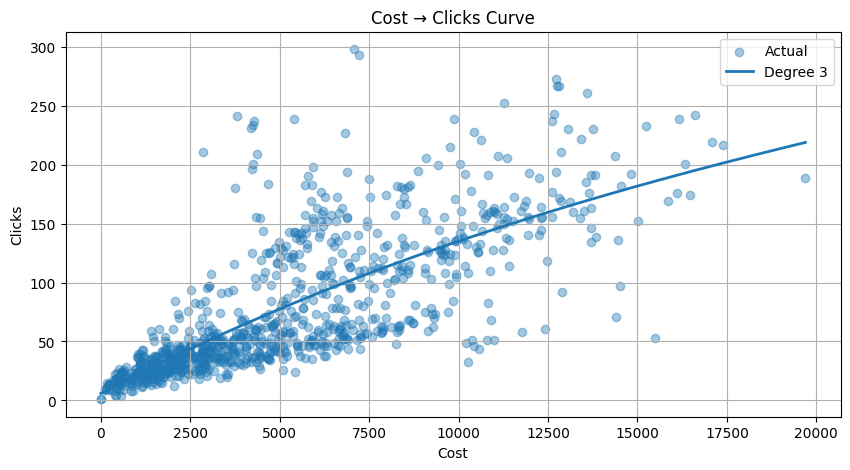

Segment: 1
  Samples: 988
  Best Degree: 3
  RMSE: 25.64
  R²: 0.608
  Estimated Cost for 500 Clicks: 26942.51



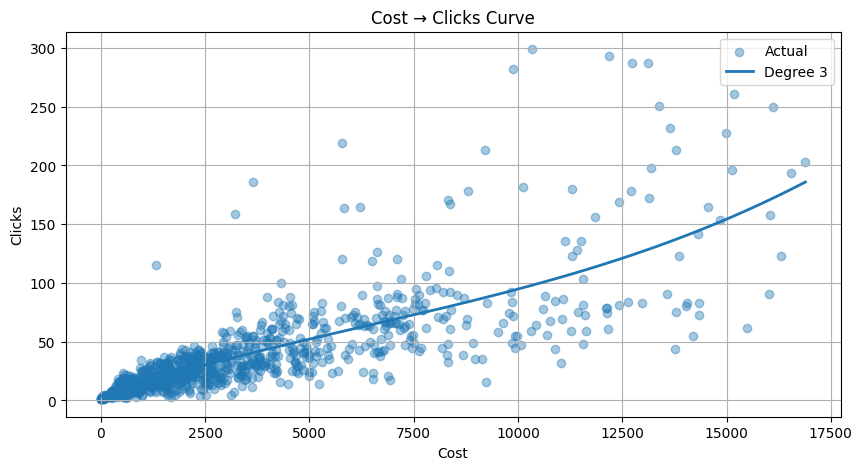

Segment: 2
  Samples: 9
  Best Degree: 3
  RMSE: 5.86
  R²: 0.993
  Estimated Cost for 500 Clicks: Cannot reach target



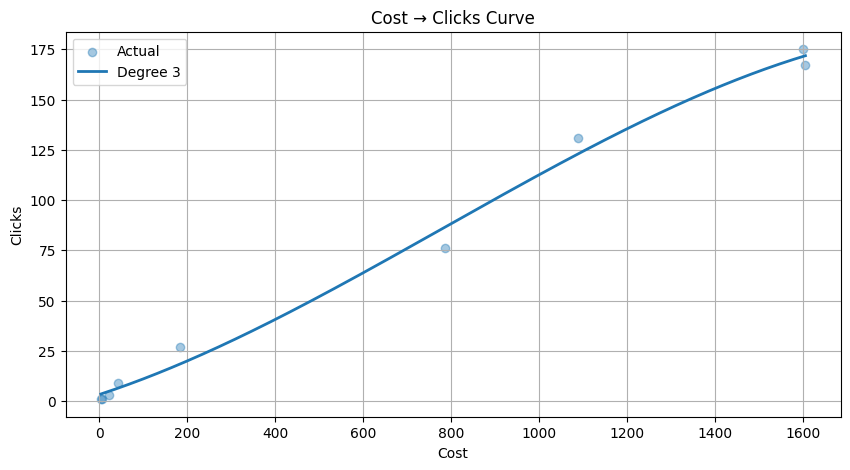

Segment: 3
  Samples: 75
  Best Degree: 3
  RMSE: 6.85
  R²: 0.756
  Estimated Cost for 500 Clicks: 32858.77



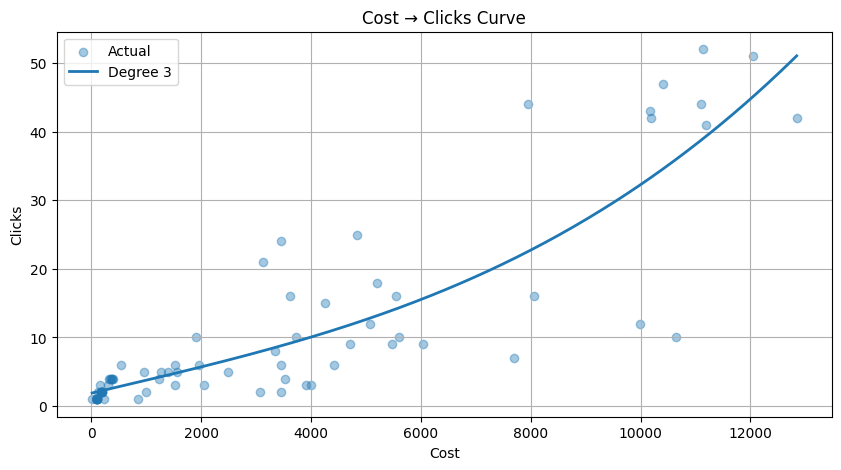

In [ ]:
metric = "Clicks"
target_value = 500

predictor = build_cost_predictor(df, metric, segmentation=True, n_segments=4)

print(f"\n=== COST PREDICTION RESULTS for {metric} ===\n")

for seg, info in predictor["segments"].items():
    print(f"Segment: {seg}")

    if "error" in info:
        print("  Error:", info["error"])
        continue

    deg = info["best_degree"]
    cost = info["predict_cost"](target_value)

    print(f"  Samples: {info['samples']}")
    print(f"  Best Degree: {deg}")
    print(f"  RMSE: {info['stats'][deg]['rmse']:.2f}")
    print(f"  R²: {info['stats'][deg]['r2']:.3f}")

    if cost is None:
        print(f"  Estimated Cost for {target_value} {metric}: Cannot reach target")
    else:
        print(f"  Estimated Cost for {target_value} {metric}: {cost:.2f}")

    print()

    plot_fitted_curve(info["data"], info["model"], info["best_degree"], metric)

plot_multi_segment_cost_curves_plotly(predictor, metric)
